### HMM EXERCISE 1 
Dirk Van Compernolle   
14/11/2019

Dependencies:  skspeech v0.1.1  , best when using matplotlib 3.1.0
(matplotlib 3.1.1.has conflicts with seaborn 0.9.0)

In [10]:
try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/scikit-speech.git
  ! pip install matplotlib==3.1.0
except:
  IN_COLAB = False

In [11]:
# do all the imports
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import skspeech.libhmm as libhmm
import skspeech.utils as u
import skspeech.libhmm_plot as hmmplot

In [12]:
# graphical and print preferences
ldesign = 50
cmap = sns.light_palette("caramel",ldesign,input="xkcd")
cmap20 = cmap[0:20] 
pd.reset_option('display.float_format')
pd.set_option('precision',3)

In [13]:
# Design a 2state silence-speech model
B = np.array([ [0.7, 0.1, 0.2], [0.1, 0.5, 0.4] ])
A = np.array([[0.7, 0.3],[0.3,0.7]])
hmm1 = libhmm.DHMM(n_states=2,states=['SIL','SP'],n_symbols=3,labels=['A','B','C'],
                   emissionprob=B, transmat=A )   
# force an alignment to end in SIL state
hmm1.end_states=[0]
hmm1.print_model()

INITIAL and TRANSITION PROBABILITIES (from,to)


,INIT,to-SIL,to-SP
SIL,1.0,0.7,0.3
SP,0.0,0.3,0.7


OBSERVATION PROBABITIES for DISCRETE DENSITY MODEL


,A,B,C
SIL,0.7,0.1,0.2
SP,0.1,0.5,0.4


In [14]:
X1 = np.array([  0, 1, 2, 0])
print("OBSERVATION SEQUENCE:\n ",hmm1.labels[X1],"\n")
trellis1 = libhmm.Trellis(n_samples=len(X1),n_states=hmm1.n_states)
trellis1.viterbi_pass(X1,hmm1)
trellis1.print(Xlabels=hmm1.labels[X1],Slabels=hmm1.states)

OBSERVATION SEQUENCE:
  ['A' 'B' 'C' 'A'] 

FRAME PROBABILIITIES and TRELLIS


,A,B,C,A
SIL,0.7,0.1,0.2,0.7
SP,0.1,0.5,0.4,0.1


,A,B,C,A
SIL,0.7,0.049,0.007,0.006
SP,0.0,0.105,0.029,0.002


BACKPOINTERS


,A,B,C,A
SIL,0,0,0,1
SP,1,0,1,1


ALIGNMENT


,0,1,2,3
X,A,B,C,A
BT,SIL,SP,SP,SIL


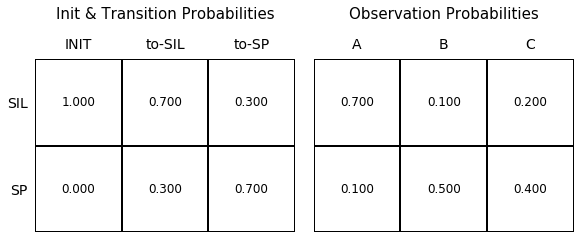

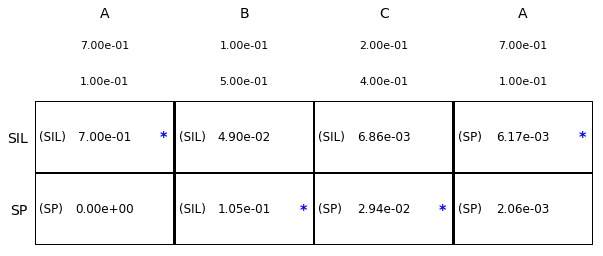

In [15]:
hmmplot.plot_model(hmm1,figsize=(8,4))
print("\n\n")
hmmplot.plot_trellis2(hmm1,X1,cmap=[],vmin=0,vmax=1,fmt=".2e",
        plot_norm=True,plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(10,4))

In [16]:
def gpdf(x,mu,sig):
    z = (x-mu)/sig
    ss = 1./(np.sqrt(2.*np.pi)*sig)
    return(ss * np.exp(-0.5*z*z))
def cdprobs(xlist):
    pdf1 = np.array([gpdf(x,20,10) for x in xlist]).reshape(-1,1)
    pdf2 = np.array([gpdf(x,50,20) for x in xlist]).reshape(-1,1)
    return( np.hstack([pdf1 , pdf2]) )

FRAME PROBABILIITIES and TRELLIS


,X0,X1,X2,X3
SIL,0.035,0.013,1.338e-05,0.035
SP,0.004,0.015,1.760e-02,0.009


,X0,X1,X2,X3
SIL,0.035,3.192e-04,2.990e-09,2.070e-08
SP,0.000,1.590e-04,1.960e-06,1.253e-08


BACKPOINTERS


,X0,X1,X2,X3
SIL,0,0,0,1
SP,1,0,1,1


ALIGNMENT


,0,1,2,3
X,X0,X1,X2,X3
BT,SIL,SP,SP,SIL


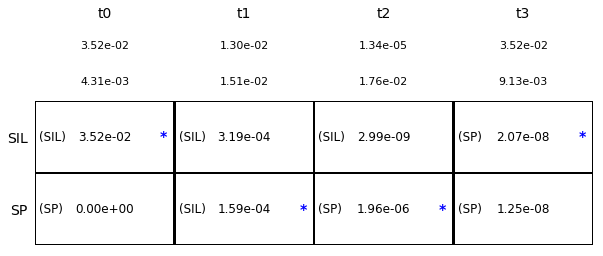

In [17]:
X2 =  [15., 35., 60.,25.]
X2probs = cdprobs(X2)
#print(X2probs.shape,X2probs)
hmm2 =  libhmm.DirectHMM(n_states=2,states=['SIL','SP'],transmat=A ) 
trellis2 = libhmm.Trellis(n_samples=len(X2),n_states=hmm1.n_states)
trellis2.viterbi_pass(X2probs,hmm2)
trellis2.print(Slabels=hmm1.states)
print("\n\n")
hmmplot.plot_trellis2(hmm2,X2probs,cmap=[],vmin=0,vmax=1,fmt=".2e",
        plot_norm=True,plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(10,4))

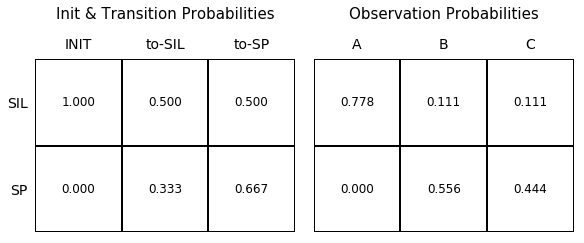

In [21]:
# Sample training code for discrete density training
#
X2=[1,0,1,1,2,0]
X3=[0,1,2,1,2,0,2,0]
S2=[0,0,1,1,1,0]
S3=[0,1,1,1,1,0,0,0]
train_set = []
train_set.append({'X':X1,'S':trellis1.alignment})
train_set.append({'X':X2,'S':S2})
train_set.append({'X':X3,'S':S3})

def viterbi_train(trn,n_labels=1,n_states=1):
    n_train = len(trn)
    obs_counts = np.zeros((n_states,n_labels),dtype='float')
    init_counts = np.zeros(n_states,dtype='float')
    trans_counts = np.zeros((n_states,n_states),dtype='float')
    # counting
    for i in range(0,n_train):
        init_counts[trn[i]["S"][0]] += 1.
        for j in range(len(trn[i]["X"])):
            obs_counts[trn[i]["S"][j],trn[i]["X"][j]] += 1.
            if j>0:
                trans_counts[ trn[i]["S"][j-1],trn[i]["S"][j] ] += 1.
    state_counts = np.sum(obs_counts,axis=1)
    op = obs_counts / state_counts[:,np.newaxis]
    tp = trans_counts / np.sum(trans_counts,axis=1)[:,np.newaxis]
    ip = init_counts / np.sum(init_counts)
    return op,tp,ip

op, tp, ip = viterbi_train(train_set,n_labels=3,n_states=2)
hmm_retrained = libhmm.DHMM(n_states=2,states=['SIL','SP'],n_symbols=3,labels=['A','B','C'],
                   emissionprob=op, transmat=tp, startprob=ip )
hmmplot.plot_model(hmm_retrained,figsize=(8,4))
